In [1]:
import json
import vk_api
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

In [2]:
with open('group.json') as f:
    group = json.load(f)

In [3]:
# вставь свой телефон и пароль от вк
vk_session = vk_api.VkApi('+7', '')
vk_session.auth()

vk = vk_session.get_api()

In [4]:
class Person:
    def __init__(self, id, name, vk_id):
        self.id = id
        self.name = name
        self.vk_id = int(vk_id)
        self.friends_vk_id_list = list()
        
    def set_is_accessible(self, is_accessible):
        self.is_accessible = is_accessible

In [5]:
persons = list()
# чтобы в дальнейшем не дублировать
vk_ids = list()

for member in group:
    person = Person(id=len(persons), name=member['name'], vk_id=member['vk_id'])
    persons.append(person)
    vk_ids.append(int(member['vk_id']))

In [6]:
def get_friends():
    new_persons = list()
    
#     добавление друзей в список
    for person in persons:
        if len(person.friends_vk_id_list) == 0:
            try:
                friends = vk.friends.get(user_id=person.vk_id, fields='nickname')['items']
                person.set_is_accessible(True)
            except Exception:
                person.set_is_accessible(False)
                print(f"{person.name}: аккаунт закрыт!")
                continue
                
            for friend in friends:
                if friend.get('deactivated'):
                    continue
                    
                person.friends_vk_id_list.append(friend['id'])
                
                if friend['id'] in vk_ids:
                    continue
                    
                vk_ids.append(friend['id'])
                len_summ = len(persons) + len(new_persons)     
                new_person = Person(id=len_summ,
                                    name=f"{friend['first_name']} {friend['last_name']}",
                                    vk_id=friend['id'])
                new_person.set_is_accessible(friend['can_access_closed'])
                new_persons.append(new_person)

    persons.extend(new_persons)
    
#     добавление оставшимся их списка друзей
    for person in persons:
        if len(person.friends_vk_id_list) == 0 and person.is_accessible:
            try:
                friends = vk.friends.get(user_id=person.vk_id, fields='nickname')['items']
            except Exception as err:
                print(err)
                print(person.__dict__)
                continue
                
            for friend in friends:
                if friend.get('deactivated'):
                    continue

                person.friends_vk_id_list.append(friend['id'])

In [ ]:
# займет примерно минут 15
get_friends()

In [8]:
n = len(persons)
R = np.zeros((n, n), dtype=int)

for i, first_person in enumerate(persons):
    for j, second_person in enumerate(persons):
        if first_person != second_person and second_person.vk_id in first_person.friends_vk_id_list:
            R[i][j] = 1
            R[j][i] = 1

In [9]:
def draw(G, pos, measures, measure_name):
    print(measure_name)
    
    plt.figure(figsize=(16, 10))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.cool, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    edges = nx.draw_networkx_edges(G, pos)


    max_value = max(measures.values())
    indices = [i for i, v in measures.items() if v == max_value]

    for index in indices:
        person = persons[index]
        print(person.id, person.name, person.vk_id)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.savefig(f"{measure_name}.pdf")
    plt.show()

Closeness_centrality
11 Романадзе Екатерина Левановна 35505055


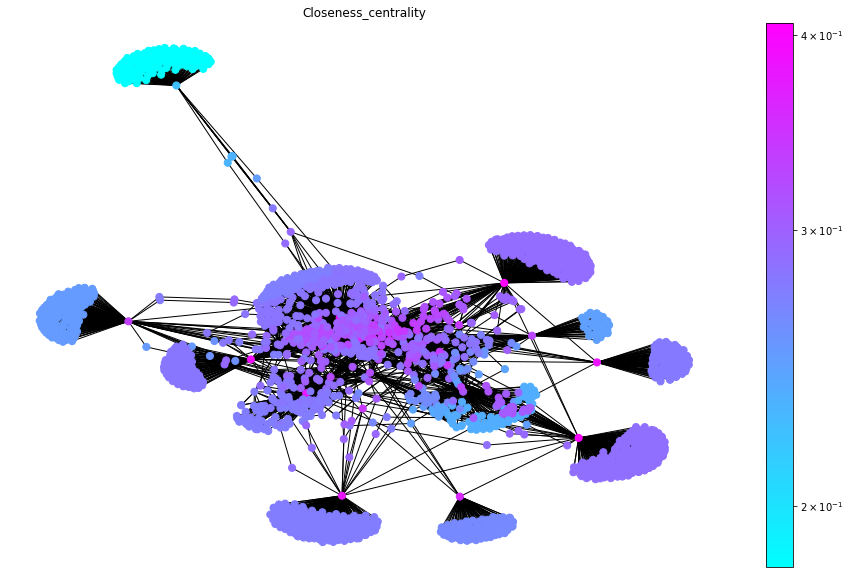

Betweenness_centrality
1 Воробьева Арина Сергеевна 85567121


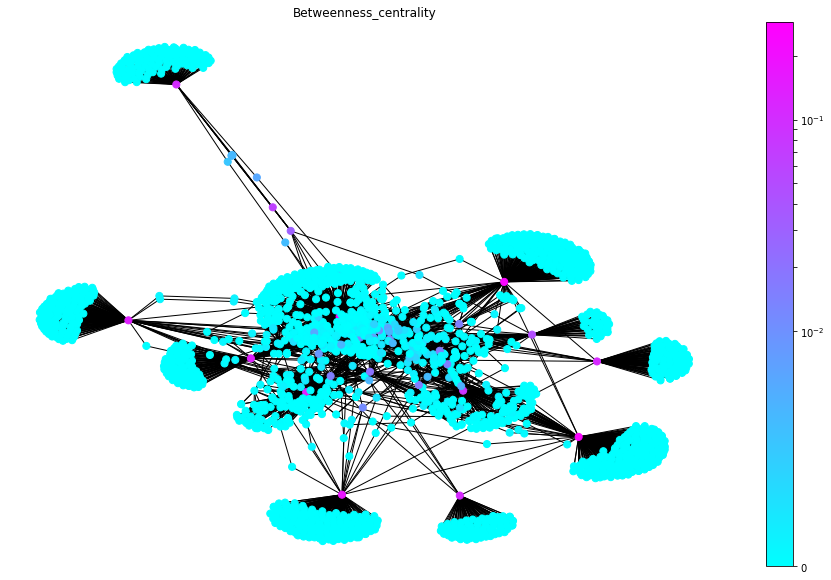

Eigenvector_centrality
1 Воробьева Арина Сергеевна 85567121


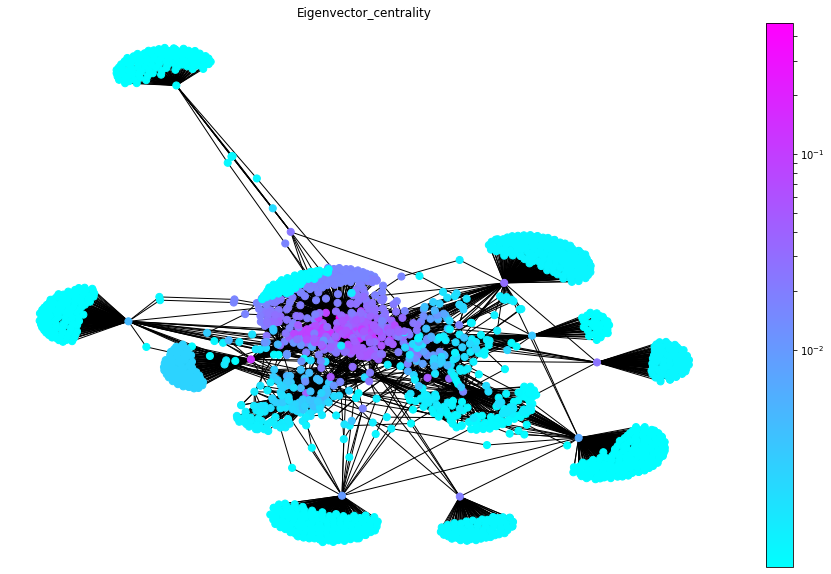

CPU times: user 48.5 s, sys: 271 ms, total: 48.7 s
Wall time: 48.8 s


In [10]:
%%time
    
rows, cols = np.where(R == 1)
edges = zip(list(rows), list(cols))
G = nx.Graph()
G.add_nodes_from(node for node in range(len(persons)))
G.add_edges_from(edges)
pos = nx.spring_layout(G)

draw(G, pos, nx.closeness_centrality(G), 'Closeness_centrality')
draw(G, pos, nx.betweenness_centrality(G), 'Betweenness_centrality')
draw(G, pos, nx.eigenvector_centrality(G, max_iter=500), 'Eigenvector_centrality')

## Подходит только для использования в рамках группы.

In [ ]:
# %%time
# D = np.where(R == 0, np.inf, R)
# np.fill_diagonal(D, 0)

# prev = [[i for j in range(n)] for i in range(n)]

# for i in range(n):
#     for j in range(n):
#         for k in range(n):
#             if D[j][i] + D[i][k] < D[j][k]:
#                 D[j][k] = D[j][i] + D[i][k]
#                 prev[j][k] = prev[i][k]

Если зполнять prev i и менять на prev[i][k], то при поиске будет последняя вершина из которой надо идти, однако, если до вершины нельзя добраться будет номер строки. И если путь проходят прямиком в вершину то тоже будет номер строки.

In [ ]:
# def get_shortest_path(fr , to):
#     path = list()
    
#     while to != fr:
#         last = prev[fr][to]
#         if last == fr:
#             if R[fr][to] == 1:
#                 return path
#             else:
#                 return None
#         else:
#             to = last
#             path.append(to)
    
#     return path[::-1]

## Центральность по близости

In [ ]:
# def closeness_centrality():
#     distance_summ = list()

#     for row in D:
#         distance_summ.append(np.sum(row[row != np.inf]))

#     distance_summ = np.array(distance_summ)
#     c = np.where(distance_summ == 0, -np.inf, 1 / distance_summ)

#     indices = np.where(c == np.amax(c))[0]
    
#     return indices

In [ ]:
# closeness_centrality()

## Центральность по посредничеству

In [ ]:
# def betweenness_centrality():
#     list_of_shortest_paths = list()

#     for i in range(n):
#         for j in range(i, n):
#             if i != j:
#                 path = get_shortest_path(i, j)
#                 if path:
#                     list_of_shortest_paths.append(path)

#     list_of_shortest_paths = np.hstack(list_of_shortest_paths)

#     (unique, counts) = np.unique(list_of_shortest_paths, return_counts=True)

#     max_occurrence = np.amax(counts)

#     indices = np.where(counts == max_occurrence)[0]

#     vertices = unique[indices]

#     return vertices

In [ ]:
# betweenness_centrality()

## Центральность по собственному вектору

In [ ]:
# def eigenvector_centrality(eps=0.001, min_rand=0, max_rand=1):  
#     vertex_values = np.array([random.randint(min_rand, max_rand) for i in range(n)])
#     max_diff = 1

#     while max_diff > eps:
#         new_vertex_values = list()

#         for i, arr in enumerate(R):
#             indices = np.where(arr == 1)[0]

#             if len(indices) != 0:
#                 values = vertex_values[indices]
#                 mean = np.mean(values) 
#             else:
#                 mean = 0

#             new_vertex_values.append(mean)

#         max_diff = np.amax(np.abs(vertex_values - new_vertex_values))
#         vertex_values = np.array(new_vertex_values)
    
#     return np.argmax(vertex_values)

In [ ]:
# def the_most_frequent_of_eigenvector(count=100):
#     (unique, counts) = np.unique([ eigenvector_centrality() for i in range(count)], return_counts=True)
#     print(unique)
#     print(counts)
#     indices = np.where(counts == np.amax(counts))[0]

#     vertices = unique[indices]

#     return vertices

In [ ]:
# the_most_frequent_of_eigenvector()